#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час, построив модель.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48 заказов.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li>
        <li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li>
        <li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li>
        <li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li>
        <li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li>
    </ul>
</div>

## Подготовка

Установим/обновим и подключим необходимые библиотеки и выставим полезные умолчания.

In [3]:
!pip install pandas scikit-learn statsmodels lightgbm -U

  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)


In [58]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from urllib.error import HTTPError
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, 
                                     GridSearchCV)

plt.style.use('dark_background');            # Dark theme for plots
plt.rc('grid', color=(.3, .3, .3));          # Pale grid lines
plt.rc('axes', grid=True, axisbelow=True);   # Grid lines behind the plot
pd.set_option('display.max_rows', 100);      # Display 100 dataframe rows
pd.set_option('display.max_columns', None);  # Display all dataframe columns

# Disable warnings
pd.options.mode.chained_assignment = None    
warnings.simplefilter('ignore', pd.errors.PerformanceWarning) 

Зафиксируем random state.

In [59]:
# Custom random state
RS = 22221111

Загрузим датасет и взглянем на него.

In [60]:
path = '/datasets/taxi.csv'
if not os.path.exists(path): 
    path = 'https://code.s3.yandex.net' + path
try:
    df = pd.read_csv(path, index_col=[0], parse_dates=[0], dtype='uint8')
    print('Success: ' + path)
except HTTPError as err:
    print(f'{err} {path}')

Success: https://code.s3.yandex.net/datasets/taxi.csv


In [61]:
df = df.sort_index().squeeze()  # Convert to pd.Series

In [62]:
df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Series name: num_orders
Non-Null Count  Dtype
--------------  -----
26496 non-null  uint8
dtypes: uint8(1)
memory usage: 232.9 KB


In [63]:
df.head()

datetime
2018-03-01 00:00:00     9
2018-03-01 00:10:00    14
2018-03-01 00:20:00    28
2018-03-01 00:30:00    20
2018-03-01 00:40:00    32
Name: num_orders, dtype: uint8

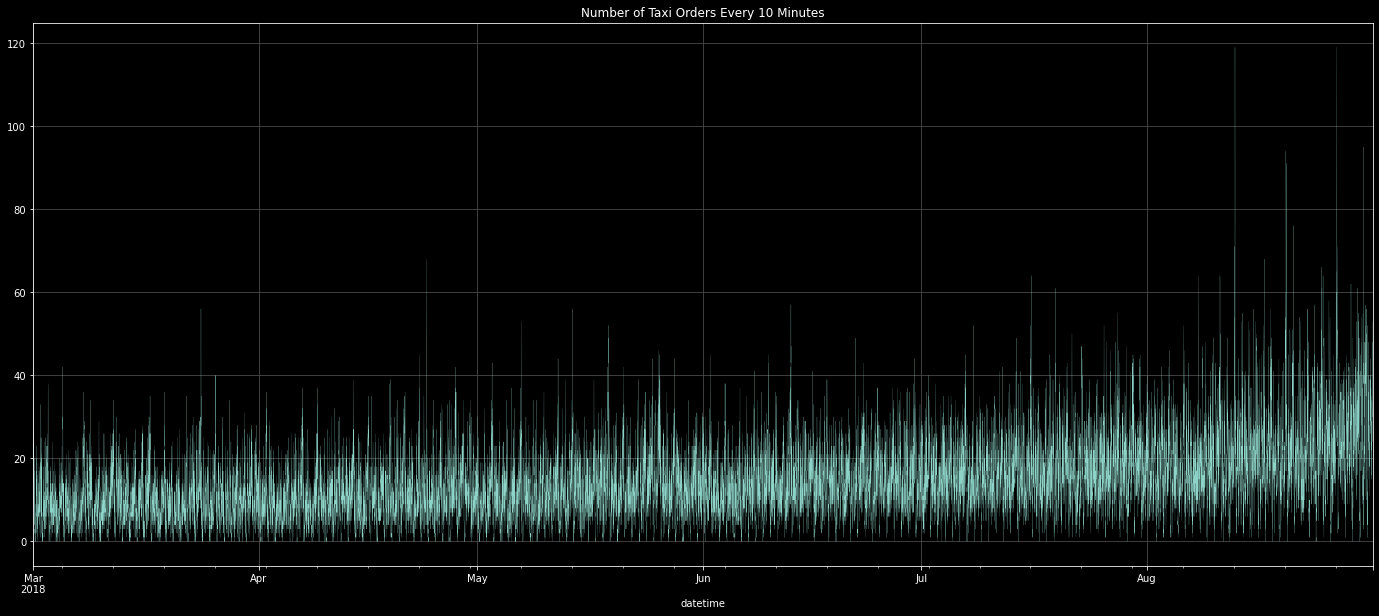

In [64]:
df.plot(figsize=(24, 10), linewidth=.15, 
        title='Number of Taxi Orders Every 10 Minutes');

Имеем данные с марта по август 2018 года с детализацией до 10 минут.

## Анализ

Агрегируем данные до почасовых и рассмотрим внимательнее.

In [65]:
df = df.resample('1H').sum().astype('uint16')
df.head()

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
Freq: H, Name: num_orders, dtype: uint16

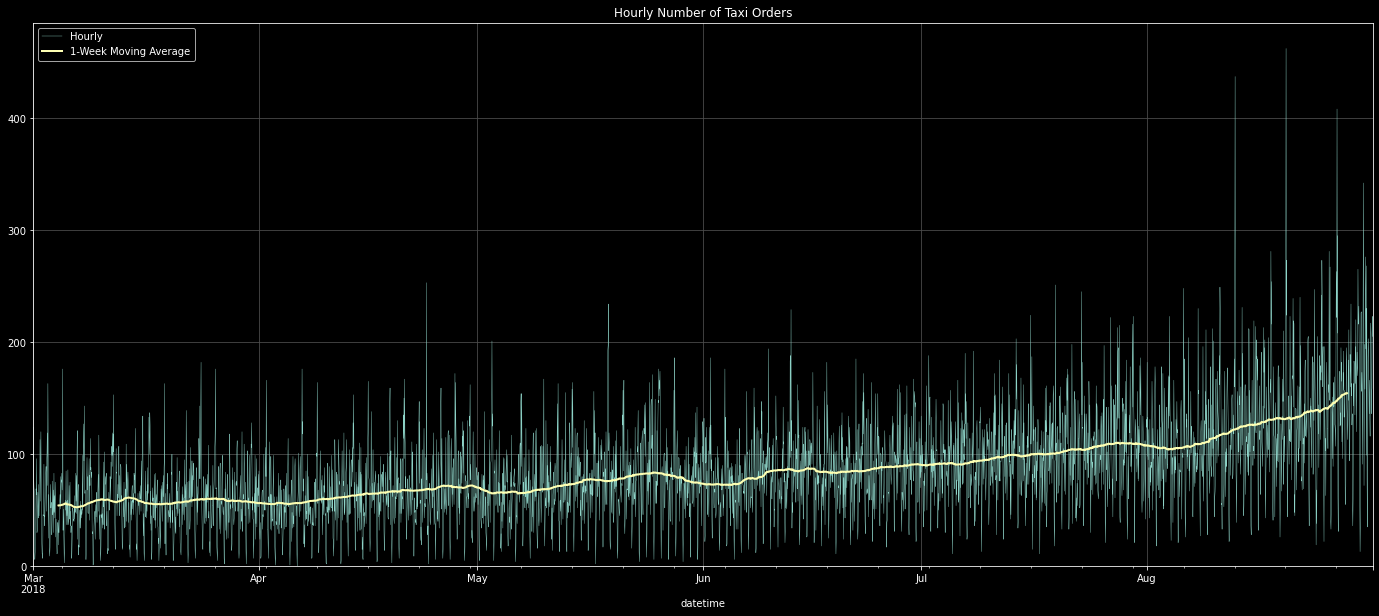

In [66]:
df.plot(figsize=(24, 10), linewidth=.4, ylim=(0), 
        title='Hourly Number of Taxi Orders');
df.rolling(7*24).mean().shift(-7*24//2).plot(linewidth=2);
plt.legend(['Hourly', '1-Week Moving Average']);

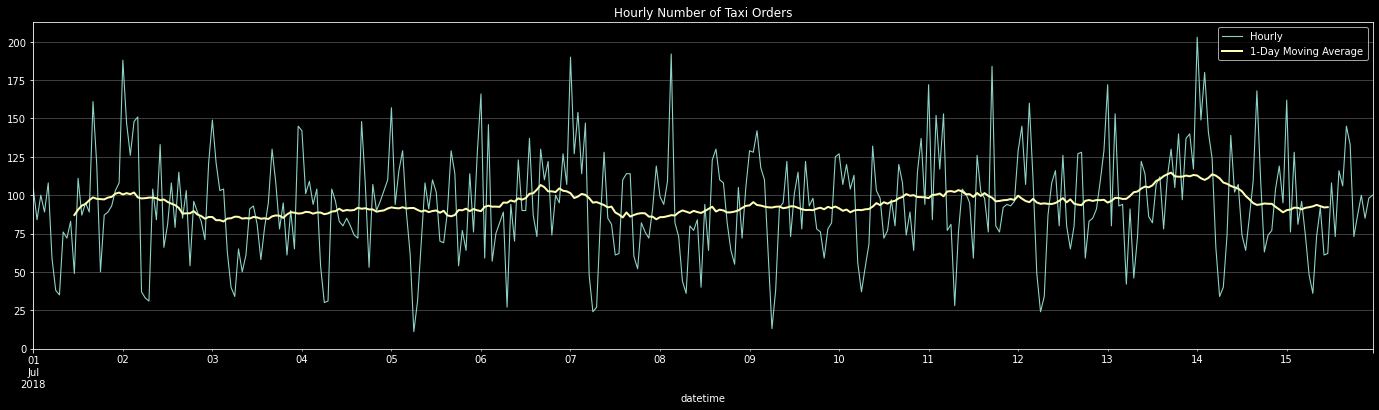

In [67]:
t1, t2 = '2018-07-01', '2018-07-15'
df[t1:t2].plot(figsize=(24, 6), linewidth=1.1, ylim=(0), 
               title='Hourly Number of Taxi Orders');
df[t1:t2].rolling(24).mean().shift(-24//2).plot(linewidth=2);
plt.legend(['Hourly', '1-Day Moving Average']);

18.110345339010976

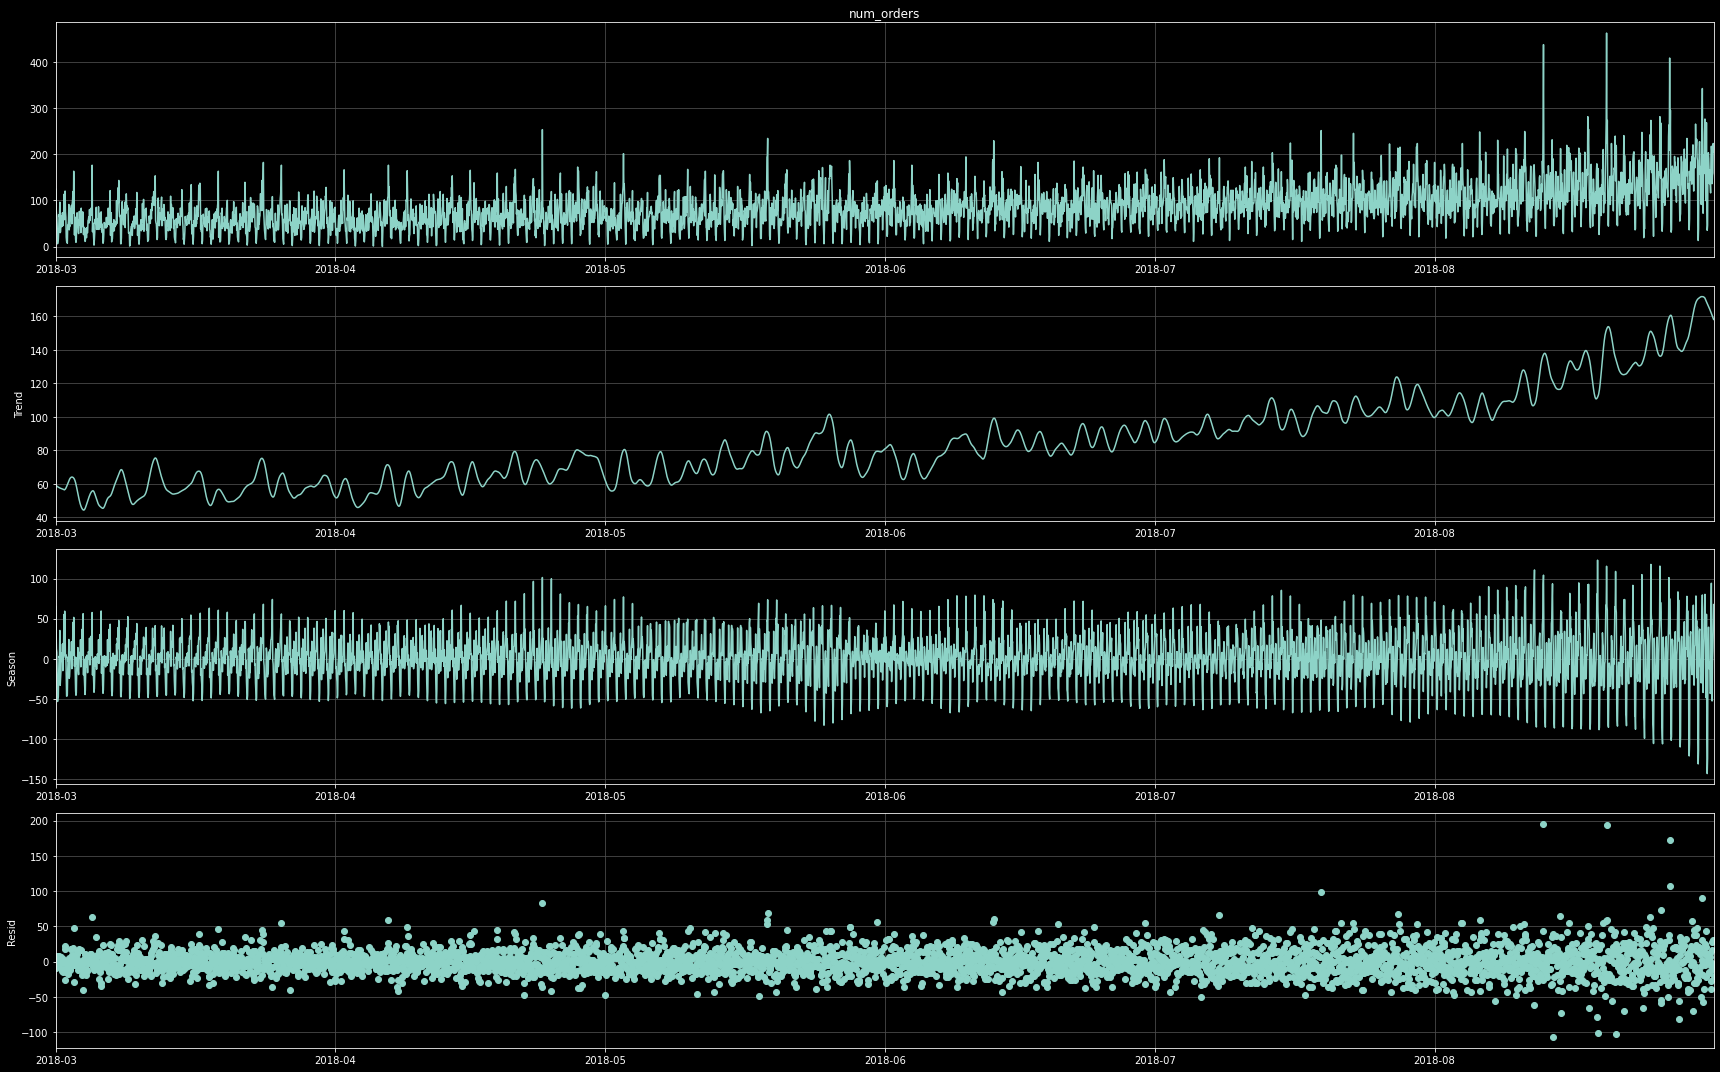

In [68]:
stl = STL(df).fit()

fig = stl.plot()
fig.set_size_inches((24, 15))
fig.tight_layout()
    
(stl.resid**2).mean()**.5

В данных присутствует сильная [внутри]суточная сезонность и слабая [внтури]недельная. Наклон тренда и амплитуда сезонной компоненты со временем увеличиваются, что особенно заметно в августе.

## Обучение

Напишем удобное сокращение функции RMSE.

In [69]:
def rmse(y_true, y_pred):
    '''Shortcut for RMSE metric'''
    return mean_squared_error(y_true, y_pred, squared=False)

Напишем функцию-генератор фич: лагов и скользящего среднего. Так как данные охватывают всего полгода, значения года и месяца будут бесполезными для моделей. Значение дня будет также бесполезным, потому что [внутри]месячной сезонности не наблюдается.

In [70]:
def make_features(df, ma_size=0, max_lag=0):
    '''Generates time series features for classical ML modeling'''
    
    df = df.to_frame()
    
    for lag in range(1, max_lag+1):
        df[f'lag{lag}'] = (df['num_orders'].shift(lag).fillna(method='bfill')
                           .astype('uint16'))
    
    if ma_size > 1 or ma_size == 1 and max_lag == 0:
        df[f'ma{ma_size}'] = (df['num_orders'].shift(1).rolling(ma_size).mean() 
                              .fillna(method='bfill').astype('float32'))
    
    # df['year'] = df.index.year.values.astype('uint16')        # Useless
    # df['month'] = df.index.month.values.astype('uint8')       # Useless
    # df['day'] = df.index.day.values.astype('uint8')           # Useless
    df['dayofweek'] = df.index.dayofweek.values.astype('uint8')
    df['hour'] = df.index.hour.values.astype('uint8')
    
    return df.drop(columns='num_orders')

Проверим работу функции.

In [71]:
make_features(df, ma_size=2, max_lag=3).head()

,lag1,lag2,lag3,ma2,dayofweek,hour
datetime,,,,,,
2018-03-01 00:00:00,124,124,124,104.5,3,0
2018-03-01 01:00:00,124,124,124,104.5,3,1
2018-03-01 02:00:00,85,124,124,104.5,3,2
2018-03-01 03:00:00,71,85,124,78.0,3,3
2018-03-01 04:00:00,66,71,85,68.5,3,4


Обернем функцию в класс-трансформер, чтобы использовать в пайплайне.

In [72]:
class MakeFeatures(BaseEstimator, TransformerMixin):
    '''Transformer that makes features from time series'''
    
    def __init__(self, ma_size=0, max_lag=0):
        self.max_lag = max_lag
        self.ma_size = ma_size
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return make_features(X, ma_size=self.ma_size, max_lag=self.max_lag)

Разобъем доступный временной период на обучающий и тестовый.

In [73]:
train, test = train_test_split(df.index, test_size=.1, shuffle=False)
len(train), len(test)

(3974, 442)

Модели и их гиперпараметры будем перебирать с помощью `GridSearchCV` библиотеки `sklearn`. Эстиматором для гридсерча будет пайплайн из генератора фичей, скейлера и самой модели.

In [74]:
pipe = Pipeline([
    ('mkf', MakeFeatures()),
    ('scl', StandardScaler()),
    ('est', None),
])

Сеткой параметров гридсерча будeт сетка параметров генератора фичей, «умноженная» на сетку моделей с их гиперпараметрами. Тестировать будем дамми-модель (среднее значение), простую линейную регрессию, линейную регрессию с комбинированной регуляризацией ElasticNet и градиентный бустинг LightGBM.

In [75]:
features_grid = dict(
    mkf__ma_size = [24, 7*24],
    mkf__max_lag = [24, 7*24],
)

In [76]:
estimators_grid = [
    dict(
        mkf=[None],
        scl=[None],
        est=[DummyRegressor()],
    ),
    dict(
        est=[LinearRegression()],
    ),
    dict(
        est=[ElasticNet(max_iter=10000, random_state=RS)],
        est__alpha=[1, .1],
        est__l1_ratio=[.5, .9, 1],
    ),
    dict(
        scl=[None],
        est=[LGBMRegressor(seed=RS)],
        est__n_estimators=[1000],
        est__learning_rate=[.1, .05, .01],
    ),
]

In [77]:
param_grid = [
    dct if 'mkf' in dct and dct['mkf'] == [None]
    else dict(dct, **features_grid) 
    for dct in estimators_grid 
]
param_grid

[{'mkf': [None], 'scl': [None], 'est': [DummyRegressor()]},
 {'est': [LinearRegression()],
  'mkf__ma_size': [24, 168],
  'mkf__max_lag': [24, 168]},
 {'est': [ElasticNet(max_iter=10000, random_state=22221111)],
  'est__alpha': [1, 0.1],
  'est__l1_ratio': [0.5, 0.9, 1],
  'mkf__ma_size': [24, 168],
  'mkf__max_lag': [24, 168]},
 {'scl': [None],
  'est': [LGBMRegressor(seed=22221111)],
  'est__n_estimators': [1000],
  'est__learning_rate': [0.1, 0.05, 0.01],
  'mkf__ma_size': [24, 168],
  'mkf__max_lag': [24, 168]}]

In [78]:
print('Number of Candidates:',
      sum([np.prod([len(lst) for lst in dct.values()]) for dct in param_grid]))

Number of Candidates: 41


Запускаем гридсерч на обучающем периоде.

In [79]:
%%time
model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    cv=TimeSeriesSplit(3),
).fit(df[train], df[train])

Fitting 3 folds for each of 41 candidates, totalling 123 fits
CPU times: total: 859 ms
Wall time: 1min 11s


In [80]:
print('Best mean CV error:', -model.best_score_)
print('Best estimator:')
model.best_estimator_

Best mean CV error: 23.763465881347656
Best estimator:


Pipeline(steps=[('mkf', MakeFeatures(ma_size=168, max_lag=168)),
                ('scl', StandardScaler()),
                ('est',
                 ElasticNet(alpha=0.1, l1_ratio=1, max_iter=10000,
                            random_state=22221111))])

Сильнейшей оказалась модель ElasticNet с лагами на неделю назад и недельным скользящим средним. Посмотрим на результаты ее конкурентов.

In [81]:
cv_results = pd.DataFrame(model.cv_results_)
(
    cv_results.sort_values('mean_test_score')
    .groupby(cv_results['param_est'].apply(lambda est: est.__class__.__name__))
    .last().sort_values('rank_test_score')
    .reindex(sorted(cv_results.columns), axis=1)
    [['mean_test_score'] + sorted([*{'param_'+prm for dct in param_grid 
                                     for prm in dct if prm != 'est'}])]
    .dropna(axis=1, how='all').fillna('')
)

,mean_test_score,param_est__alpha,param_est__l1_ratio,param_est__learning_rate,param_est__n_estimators,param_mkf__ma_size,param_mkf__max_lag
param_est,,,,,,,
ElasticNet,-23.763466,0.1,1.0,,,168.0,168.0
LinearRegression,-24.137281,,,,,168.0,168.0
LGBMRegressor,-25.957211,,,0.05,1000.0,168.0,168.0
DummyRegressor,-42.586610,,,,,,


Линейные модели победили бустинг. Раз так, посмотрим на топ коэффициентов линейной регрессии, чтобы понять, какие фичи оказались самыми значимыми.

In [82]:
params = model.best_estimator_.get_params()
coefs = pd.DataFrame(
    params['est'].coef_, columns=['coef'],
    index=MakeFeatures(params['mkf__ma_size'], params['mkf__max_lag'])
          .transform(df).columns
)
coefs = coefs.reindex(coefs['coef'].abs().sort_values(ascending=False).index)
coefs.head(15)

,coef
ma168,11.206992
lag168,11.198954
lag48,4.953121
lag1,4.138345
lag72,3.891271
lag24,3.618599
lag96,3.500076
lag120,3.371403
lag2,2.401331
lag70,-2.029469


Самыми значимыми фичами стали скользящее среднее (недельное) и 168-й лаг (на неделю назад). Далее с большим отрывом следуют лаги в 1–5 суток вперемешку с лагами 1 и 2. Потом все остальные лаги с малыми коэффициентами разных знаков. То есть победившая модель – это, по сути, среднее арифметическое недельного скользящего среднего и значения таргета ровно неделю назад с примесями таргетов 1–5-суточной давности, а также таргетов на 1 и 2 шага назад. Остальное – шум. Значит при необходимости более серьезной оптимизации генератор фич можно порядком проредить, оставив недельное скользящее среднее, пару ближайших лагов и 7 ближайших суточных лагов.

Посмотрим, насколько визуально близки предсказания модели к истинным значениями.

In [83]:
pred = pd.Series(model.predict(df[train]), index=train)

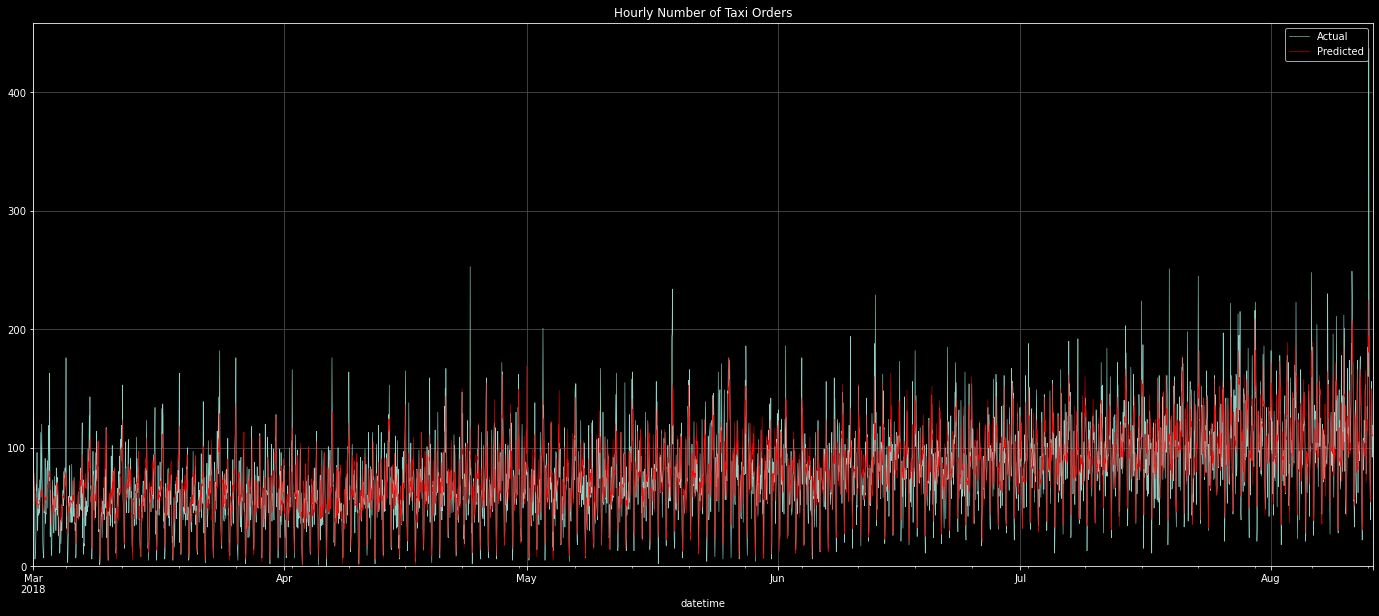

In [84]:
df[train].plot(figsize=(24, 10), linewidth=.6, alpha=1, ylim=(0),
               title='Hourly Number of Taxi Orders');
pred.plot(color='r', linewidth=.5, alpha=1);
plt.legend(['Actual', 'Predicted']);

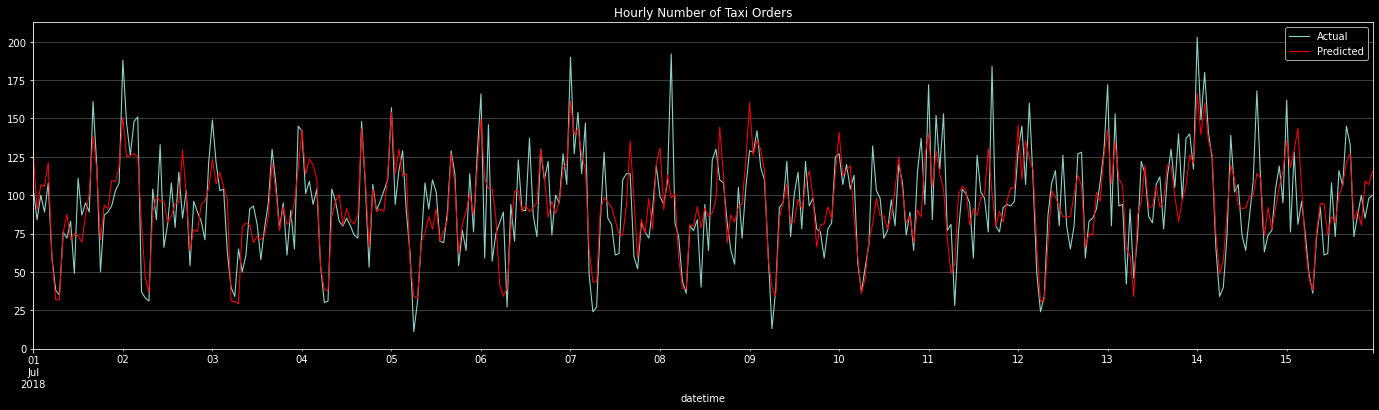

In [85]:
t1, t2 = '2018-07-01', '2018-07-15'
df[train][t1:t2].plot(figsize=(24, 6), linewidth=1.1, alpha=1, ylim=(0), 
                      title='Hourly Number of Taxi Orders');
pred[t1:t2].plot(color='r', linewidth=1, alpha=1);
plt.legend(['Actual', 'Predicted']);

Выглядит неплохо.

## Тестирование

Проверим лучшую модель на тестовом периоде. RMSE константной дамми-модели посчитаем для сравнения.

In [86]:
rmse(df[test], DummyRegressor().fit(df[train], df[train]).predict(df[test]))

84.74414402014742

In [87]:
pred = pd.Series(model.predict(df[test]), index=test)
rmse(df[test], pred)

39.50931

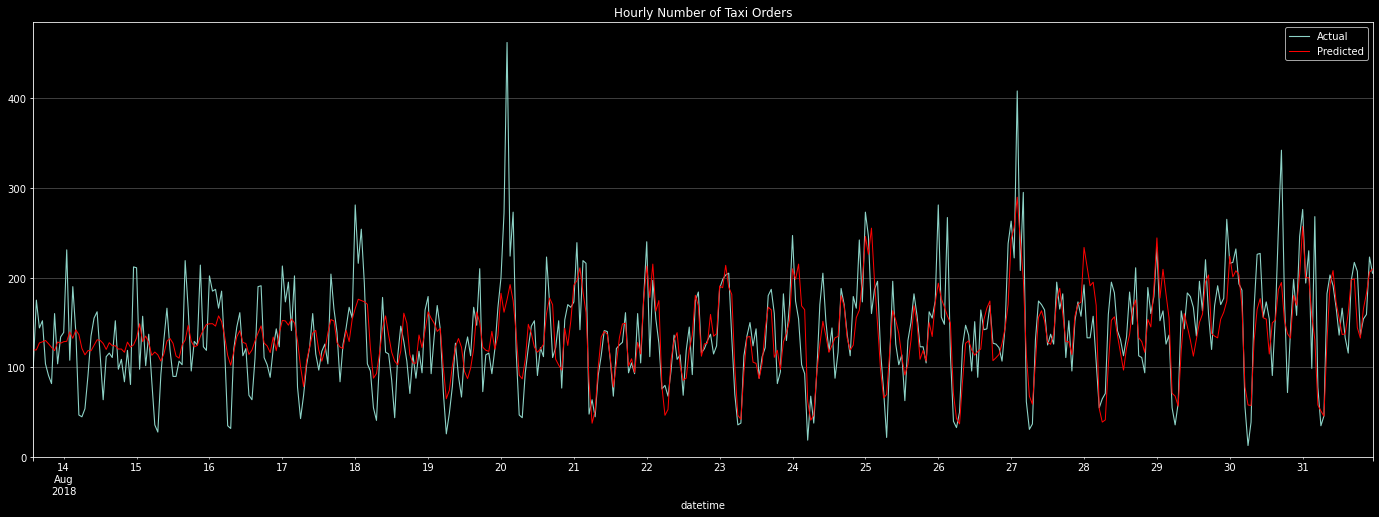

In [88]:
df[test].plot(figsize=(24, 8), linewidth=1.1, alpha=1, ylim=(0),
              title='Hourly Number of Taxi Orders');
pred.plot(color='r', linewidth=1, alpha=1);
plt.legend(['Actual', 'Predicted']);

RMSE на тестовом периоде сильно ухудшилась. Основная причина этого в нескольких больших выбросах (в обучающем периоде был только один сильный выброс на вдевятеро большее число точек). Менее значимая причина в том, что первую треть периода модель ошибается сильнее, потому что частично работает на константных лагах и констанотном скользящем среднем, которыми заполнены пропуски первых значений при генерации фич. 

Тем не менее целевое значение RMSE на тестовой выборке – 48 заказов – достигнуто с запасом. Обучим модель на всем датасете.

In [89]:
prod = model.best_estimator_.fit(df, df)
prod

Pipeline(steps=[('mkf', MakeFeatures(ma_size=168, max_lag=168)),
                ('scl', StandardScaler()),
                ('est',
                 ElasticNet(alpha=0.1, l1_ratio=1, max_iter=10000,
                            random_state=22221111))])

В продакшн! :)